## Importar librerias

In [11]:
# Manejo de datos
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Gráficos (Incluidos únicamente en el archivo .ipybn)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version skforecast: {skforecast.__version__}")
print(f"{color}- Version scikit-learn: {sklearn.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")

Versión de las librerias utilizadas:
- Version skforecast: 0.16.0
- Version scikit-learn: 1.6.1
- Version pandas: 2.2.3
- Version numpy: 2.2.4


## Funciones de utilidad

In [12]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

## Lectura del dataset

In [ ]:
# Cargar el archivo Excel
df = pd.read_excel("acceso.xlsx")

# Leer días de vacaciones desde un archivo txt
with open('dias_vacaciones.txt', 'r') as f:
    dias_vacaciones = [pd.to_datetime(line.strip(), errors='coerce') for line in f if line.strip()]

# Asegurar que la fecha esté en formato datetime
df['Fecha Completa'] = pd.to_datetime(df['Fecha Completa'])

# Crear variables temporales relevantes
df['Día'] = df['Fecha Completa'].dt.day
df['Mes'] = df['Fecha Completa'].dt.month
df['Año'] = df['Fecha Completa'].dt.year

# Codificar Jornada, Pregrado y Postgrado
df['Jornada'] = df['Jornada'].astype('category').cat.codes
df['Pregrado'] = df['Pregrado'].map({'SI': 1, 'NO': 0})
df['Postgrado'] = df['Postgrado'].map({'SI': 1, 'NO': 0})

# Crear una clave de fecha sin hora
df['Fecha'] = df['Fecha Completa'].dt.date

# Crear columna exógena de vacaciones
df['Vacaciones'] = df['Fecha Completa'].dt.normalize().isin(dias_vacaciones).astype(int)

# Agrupar y contar accesos
daily_counts = df.groupby(['Fecha', 'Día', 'Mes', 'Año']).agg({
    'Pregrado': 'sum',
    'Postgrado': 'sum',
    'Fecha Completa': 'count',  # esto cuenta los accesos
    'Vacaciones': 'max'  # max para saber si es día de vacaciones
}).rename(columns={'Fecha Completa': 'Accesos'}).reset_index()

# Crear rango completo de fechas
fecha_inicio = df['Fecha'].min()
fecha_fin = df['Fecha'].max()
fechas_completas = pd.DataFrame({'Fecha': pd.date_range(fecha_inicio, fecha_fin)})

# Extraer día, mes y año para el rango completo
fechas_completas['Día'] = fechas_completas['Fecha'].dt.day
fechas_completas['Mes'] = fechas_completas['Fecha'].dt.month
fechas_completas['Año'] = fechas_completas['Fecha'].dt.year
fechas_completas['Fecha'] = fechas_completas['Fecha'].dt.date 

# Marcar vacaciones en el rango completo
fechas_completas['Vacaciones'] = pd.to_datetime(fechas_completas['Fecha']).isin(dias_vacaciones).astype(int)

# Unir con daily_counts
daily_counts_full = fechas_completas.merge(
    daily_counts.drop(columns=['Vacaciones']),  # quitamos la columna para evitar duplicados
    on=['Fecha', 'Día', 'Mes', 'Año'],
    how='left'
)

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)


FileNotFoundError: [Errno 2] No such file or directory: 'acceso_duplicado.xlsx'

In [ ]:
# ...existing code...

# Rellenar NaN con 0 en las columnas numéricas
for col in ['Pregrado', 'Postgrado', 'Accesos']:
    daily_counts_full[col] = daily_counts_full[col].fillna(0).astype(int)

# Eliminar los domingos del DataFrame
daily_counts_full = daily_counts_full[
    pd.to_datetime(daily_counts_full['Fecha']).dt.weekday != 6
].reset_index(drop=True)

# ...continúa con el resto del código...

In [ ]:
# Exportar como archivo Excel
archivo_salida = "daily_counts_full.xlsx"
daily_counts_full.to_excel(archivo_salida, index=False)

print(f"Archivo exportado como {archivo_salida}")

In [ ]:
daily_counts_full.head(10)

In [ ]:
daily_counts_full.tail(10)

In [27]:
accesos_duplicados = pd.read_excel("accesos_duplicados.xlsx")

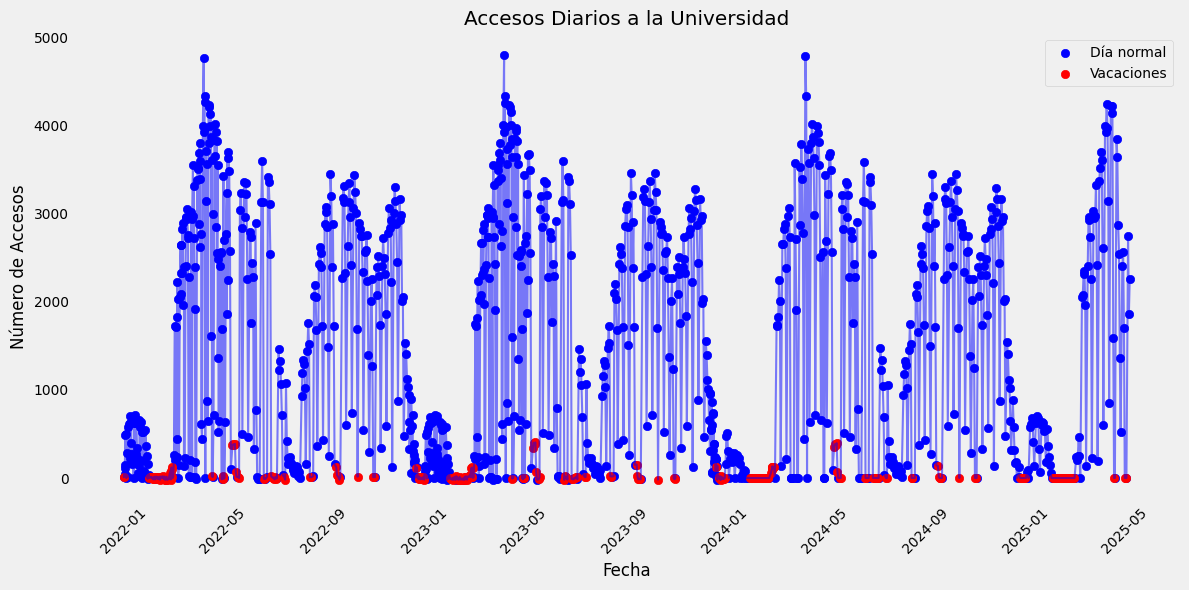

In [28]:
# Graficar los datos con puntos rojos en vacaciones
plt.figure(figsize=(12, 6))

# Línea general
plt.plot(accesos_duplicados['Fecha'], accesos_duplicados['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones)
no_vac = accesos_duplicados['Vacaciones'] == 0
plt.scatter(accesos_duplicados['Fecha'][no_vac], accesos_duplicados['Accesos'][no_vac], color='b', label='Día normal')

# Puntos de vacaciones
vac = accesos_duplicados['Vacaciones'] == 1
plt.scatter(accesos_duplicados['Fecha'][vac], accesos_duplicados['Accesos'][vac], color='r', label='Vacaciones')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## División de datos de entrenamiento y test


In [33]:
train_Size = int(len(accesos_duplicados)*0.8)

train = accesos_duplicados['Accesos'][:train_Size]
test = accesos_duplicados['Accesos'][train_Size:]

train_exog = accesos_duplicados[['Vacaciones', 'Dia_Semana', 'Día', 'Es_Sabado']][:train_Size]
test_exog = accesos_duplicados[['Vacaciones', 'Dia_Semana', 'Día', 'Es_Sabado']][train_Size:]

print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Train dates : 0 --- 1050  (n=1051)
Test dates  : 1051 --- 1313  (n=263)


In [31]:
accesos_duplicados = pd.read_excel("accesos_duplicados.xlsx")

# Agregar columnas para identificar sábados y días de la semana
accesos_duplicados['Es_Sabado'] = (accesos_duplicados['Fecha'].dt.weekday == 5).astype(int)  # 5 es sábado
accesos_duplicados['Dia_Semana'] = accesos_duplicados['Fecha'].dt.weekday.apply(lambda x: 1 if x < 5 else 0)  # 0-4 son lunes a 

## Escalar los datos

In [34]:
# Escalar solo la variable objetivo (Accesos)
scaler_y = StandardScaler()
train_scaled = scaler_y.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler_y.transform(test.values.reshape(-1, 1))

# Escalar variables exógenas (Vacaciones), si lo deseas
scaler_exog = StandardScaler()
train_exog_scaled = scaler_exog.fit_transform(train_exog)
test_exog_scaled = scaler_exog.transform(test_exog)

## Crear modelo


## Evaluación de rendimiento

In [ ]:
from skforecast.model_selection import grid_search_forecaster
import xgboost as xgb

# Configuración de validación cruzada
cv = TimeSeriesFold(
    steps=14,  # Número de pasos en el conjunto de prueba
    initial_train_size=int(len(train) * 0.5),  # Tamaño inicial del conjunto de entrenamiento
    refit=True,  # Reentrenar el modelo en cada iteración
    fixed_train_size=False  # Mantener el tamaño del conjunto de entrenamiento variable
)

# Definir los valores de hiperparámetros para el Grid Search
param_grid = {
    'n_estimators': [100, 250, 500],  # Número de árboles
    'max_depth': [3, 5, 10],          # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2] # Tasa de aprendizaje
}

lags_grid = [7, 14, 30]  # Número de rezagos a probar

# Crear el modelo base
forecaster_xgb = ForecasterRecursive(
    regressor=xgb.XGBRegressor(objective='reg:squarederror', random_state=123),
    lags=30  # Número inicial de rezagos
)

# Realizar el Grid Search
results_grid = grid_search_forecaster(
    forecaster=forecaster_xgb,
    y=train,
    exog=train_exog,
    param_grid=param_grid,
    lags_grid=lags_grid,
    cv=cv,
    metric='mean_squared_error',  # Métrica para evaluar el modelo
    return_best=True,
    verbose=True
)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(results_grid['best_params'])
print(f"Mejor número de rezagos: {results_grid['best_lags']}")
print(f"Error cuadrático medio (MSE): {results_grid['best_metric']:.2f}")

# Entrenar el modelo con los mejores hiperparámetros
forecaster_xgb = ForecasterRecursive(
    regressor=xgb.XGBRegressor(**results_grid['best_params']),
    lags=results_grid['best_lags']
)
forecaster_xgb.fit(y=train, exog=train_exog)

# Predicción con el modelo optimizado
predicted_xgb = forecaster_xgb.predict(steps=len(test), exog=test_exog)

# Evaluación del modelo optimizado
mse_xgb = mean_squared_error(test, predicted_xgb)
mae_xgb = mean_absolute_error(test, predicted_xgb)
mape_xgb = smape(test, predicted_xgb)

print(f"Error Cuadrático Medio (MSE) - XGBoost Optimizado: {mse_xgb:.2f}")
print(f"Error Absoluto Medio (MAE) - XGBoost Optimizado: {mae_xgb:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE) - XGBoost Optimizado: {mape_xgb:.2f}%")

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(accesos_duplicados['Fecha'][:train_Size], train, label='Entrenamiento', color='blue')
plt.plot(accesos_duplicados['Fecha'][train_Size:], test, label='Test', color='orange')
plt.plot(accesos_duplicados['Fecha'][train_Size:], predicted_xgb, label='Predicción XGBoost Optimizado', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad con XGBoost Optimizado')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Error Cuadrático Medio (MSE) - XGBoost: 2660983.40
Error Absoluto Medio (MAE) - XGBoost: 1158.12
Error Porcentual Absoluto Medio (MAPE) - XGBoost: 147.80%


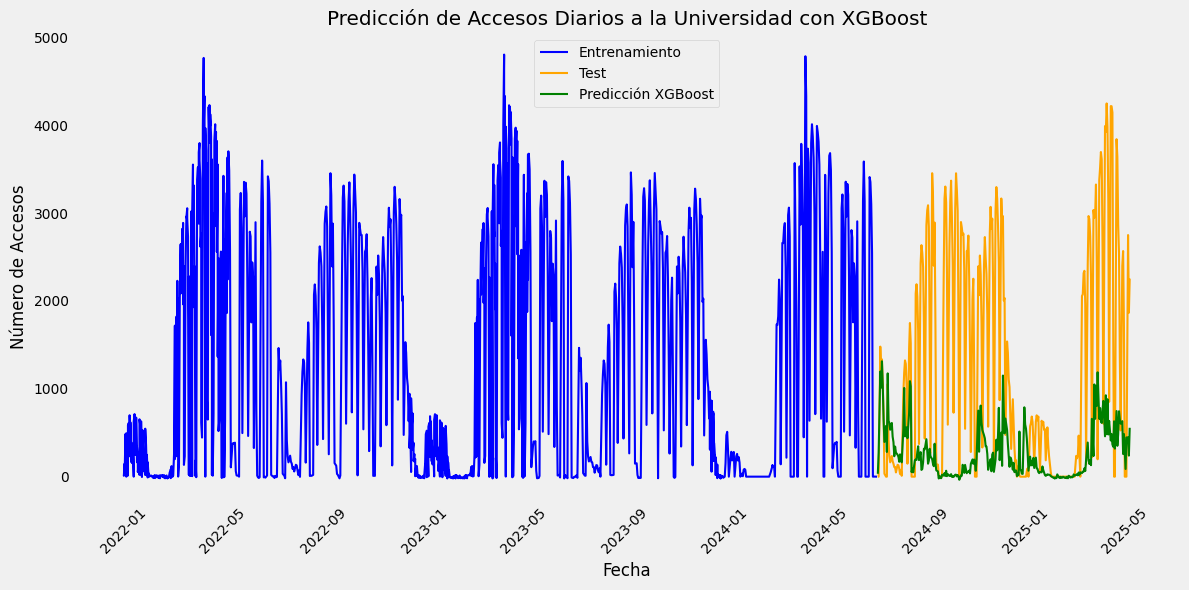

In [39]:
import xgboost as xgb
from skforecast.recursive import ForecasterRecursive
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Crear y entrenar el modelo con XGBoost
forecaster_xgb = ForecasterRecursive(
    regressor=xgb.XGBRegressor(
        objective='reg:squarederror',  # Regresión con error cuadrático
        n_estimators=100,             # Número de árboles
        max_depth=15,                  # Profundidad máxima de los árboles
        learning_rate=0.1,            # Tasa de aprendizaje
        random_state=123              # Semilla para reproducibilidad
    ),
    lags=90  # Número de rezagos
)

# Entrenar el modelo
forecaster_xgb.fit(y=train, exog=train_exog)

# Predicción con el modelo XGBoost
predicted_xgb = forecaster_xgb.predict(steps=len(test), exog=test_exog)

# Evaluación del modelo XGBoost
mse_xgb = mean_squared_error(test, predicted_xgb)
mae_xgb = mean_absolute_error(test, predicted_xgb)
mape_xgb = smape(test, predicted_xgb)

print(f"Error Cuadrático Medio (MSE) - XGBoost: {mse_xgb:.2f}")
print(f"Error Absoluto Medio (MAE) - XGBoost: {mae_xgb:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE) - XGBoost: {mape_xgb:.2f}%")

# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(accesos_duplicados['Fecha'][:train_Size], train, label='Entrenamiento', color='blue')
plt.plot(accesos_duplicados['Fecha'][train_Size:], test, label='Test', color='orange')
plt.plot(accesos_duplicados['Fecha'][train_Size:], predicted_xgb, label='Predicción XGBoost', color='green')
plt.title('Predicción de Accesos Diarios a la Universidad con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

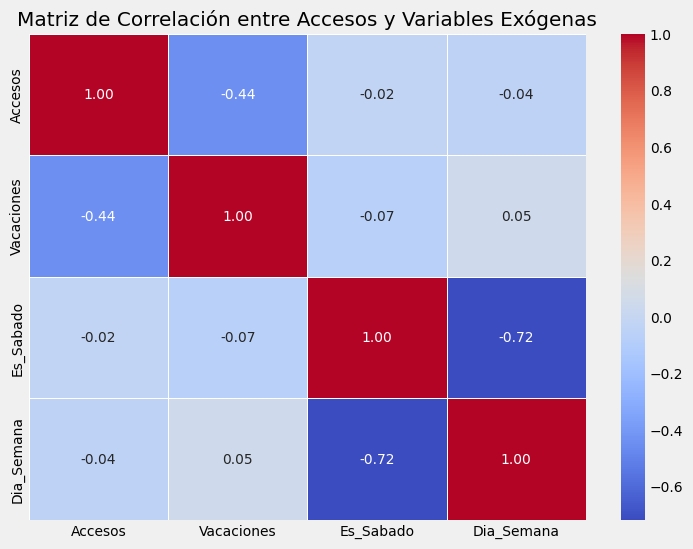

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar las columnas relevantes para la correlación
variables = ['Accesos','Vacaciones','Es_Sabado', 'Dia_Semana']
df_corr = accesos_duplicados[variables]

# Calcular la matriz de correlación
correlation_matrix = df_corr.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación entre Accesos y Variables Exógenas')
plt.show()